# Analyzing the NYC Subway Dataset

In this project I will be analyzing a sample of MTA New York City Subway data from May, 2011.  This MTA data contains hourly entries and exits to turnstiles (UNIT) in the subway system.  Joined to this data set is weather information gathered from [Weather Underground](http://www.wunderground.com) containing features such as temperature, barometric pressure, indicators for rain, fog, and thunder, and the total amount of precipitation, among others.  

I have loaded this CSV data into a pandas dataframe named ```turnstile_master``` and printed out the first five rows:

In [1]:
%matplotlib inline

import pandas as pd

turnstile_master = pd.read_csv('turnstile_data_master_with_weather.csv')
turnstile_master.head()

,Unnamed: 0,UNIT,DATEn,TIMEn,Hour,DESCn,ENTRIESn_hourly,EXITSn_hourly,maxpressurei,maxdewpti,...,meandewpti,meanpressurei,fog,rain,meanwindspdi,mintempi,meantempi,maxtempi,precipi,thunder
0,0,R001,2011-05-01,01:00:00,1,REGULAR,0,0,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
1,1,R001,2011-05-01,05:00:00,5,REGULAR,217,553,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
2,2,R001,2011-05-01,09:00:00,9,REGULAR,890,1262,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
3,3,R001,2011-05-01,13:00:00,13,REGULAR,2451,3708,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0
4,4,R001,2011-05-01,17:00:00,17,REGULAR,4400,2501,30.31,42,...,39,30.27,0,0,5,50,60,69,0,0


## Section 1: Statistical Testing

### 1.1 Statistical Test

The NYC subway data was analyzed with the Mann-Whitney U-Test.  A two-tail p-value was used as no prior assumptions are made about the contrast in the distributions of ridership on rainy and non-rainy days.  

The p-value returned by scipy.stats.mannwhitneyu is one-tailed as noted here: 

[http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mannwhitneyu.html](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mannwhitneyu.html)

In order to use a two-tailed test, the one-tailed p-value returned by scipy.stats.mannwhitneyu must be multiplied by 2.

The significance level being used in this test is 0.05 (i.e. 5% chance of observing a result as least as extreme).

### 1.2 Test Applicability

The question being asked is whether subway ridership varies with the weather.  The provided dataset allows hourly entries to MTA turnstiles to be spliced into two different samples, entries with and without rain.  The Mann-Whitney U-Test tests the null hypothesis that the two samples being compared are derived from the same population.  This null hypothesis allows us to test whether there is a statistically significant difference in ridership on rainy and non-rainy days (i.e., are the hourly entries derived from the same population).  Furthermore, exploratory data analysis (see [Section 3.1](#3.1-Distribution-of-ENTRIESn_hourly)) has shown that the data is not normally distributed.  The Mann-Whitney U-Test does not assume normality of the data, making this test appropriate.

### 1.3 Test Results

The numerical results of the Mann-Whitney U-Test are the following:

In [2]:
import numpy as np

with_rain_mean = np.mean(turnstile_master[turnstile_master.rain == 1]['ENTRIESn_hourly'])
without_rain_mean = np.mean(turnstile_master[turnstile_master.rain == 0]['ENTRIESn_hourly'])

print "Mean entries, with rain: {0}\nMean entries, without rain: {1}".format(with_rain_mean, without_rain_mean)

Mean entries, with rain: 1105.44637675
Mean entries, without rain: 1090.27878015


In [3]:
import scipy
import scipy.stats

[U, p] = scipy.stats.mannwhitneyu(turnstile_master[turnstile_master.rain == 1]['ENTRIESn_hourly'],
                                  turnstile_master[turnstile_master.rain == 0]['ENTRIESn_hourly'])

print "Mann-Whitney Test Statistic: {0}\np-Value: {1}".format(U, p)

Mann-Whitney Test Statistic: 1924409167.0
p-Value: 0.0249999127935


### 1.4 Test Significance

In [4]:
# Significance level defined in Section 1.1
alpha = 0.05

# two-tailed test
if (p * 2) < alpha:
    print 'Reject the null hypothesis'
else:
    print 'Fail to reject null hypothesis'

Reject the null hypothesis


With this small p-value, we reject the null hypothesis of the Mann-Whitney U-Test.  In other words, the distribution of the number of entries is statistically different between rainy and non-rainy days.

## Section 2: Linear Regression

### 2.1 Predicting Ridership with Ordinary Least Squares

Ordinary Least Squares (OLS) is chosen to solve the linear regression model.  The normal equation is implemented directly without the use of the Statsmodel package.  

Reference the Machine Learning course taught by Stanford’s Andrew Ng for more information on OLS and the normal equation: 

[https://d396qusza40orc.cloudfront.net/ml/docs/slides/Lecture4.pptx](https://d396qusza40orc.cloudfront.net/ml/docs/slides/Lecture4.pptx)

### 2.2 Feature Selection

The following features are taken directly from the turnstile_master dataset:

* rain
* fog
* Hour
* meantempi

In [5]:
# select features
features = turnstile_master[['rain', 'fog', 'Hour', 'meantempi']]

The following features are created by transforming data:

* precipi – The square root of the 'precipi' field in the turnstile_master dataset

In [6]:
# needed to prevent warning about chained assignment
features.is_copy = False 

# create polynomial features
features['precipi'] = turnstile_master['precipi']**0.5

Dummy variables are used to include categorical data as features in a linear model.  The dummy variables include:

* UNIT - Taken directly from the turnstile_master dataset
* weekday - The day of the week as an integer [0:6] (Monday = 0, [https://docs.python.org/2/library/datetime.html#datetime.datetime.weekday](https://docs.python.org/2/library/datetime.html#datetime.datetime.weekday))

In [7]:
# UNIT
dummy_units = pd.get_dummies(turnstile_master['UNIT'], prefix='unit')
features = features.join(dummy_units)

# weekday
from datetime import datetime

# use lambda function to get weekday from 'DATEn' field
f = lambda x: datetime.strptime(x, "%Y-%m-%d").weekday()

dummy_units = pd.get_dummies(turnstile_master['DATEn'].apply(f), prefix='weekday')
features = features.join(dummy_units)

### 2.3 Feature Selection Rationale

meantempi is chosen as a feature as temperature is a component of the weather that affects people’s decision making.  A given temperature may affect how long and how much effort it takes to clothe in the morning.  A person may simply choose to stay indoors due to discomfort with a given temperature.

Hour and weekday features were chosen as it is easily observed how ridership varies with time of day and day of week.  A phenomenon supporting the Hour feature is the daily rush hours that mass transit systems and roadways exhibit and accommodate.  An observation supporting the use of weekday is how the MTA train schedule varies between weekdays and weekends, with trains arriving with more infrequency on Saturday and Sunday. 


### 2.4 Model Results

In [8]:
# ridership values
values = turnstile_master[['ENTRIESn_hourly']]
m = len(values)

# add a column of 1s (y intercept)
features['ones'] = np.ones(m)
    
# convert features and values to numpy arrays
features_array = np.array(features)
values_array = np.array(values).flatten()
features_array_transpose = features_array.transpose()

# calculate theta and make ridership predictions
theta = np.dot(np.dot(np.linalg.pinv(np.dot(features_array_transpose, features_array)), features_array_transpose), values_array)
predictions = np.dot(features_array, theta)

After making predictions, use the coefficient of determination (R^2) to see how the model performed:

In [9]:
SST = ((turnstile_master['ENTRIESn_hourly'] - np.mean(turnstile_master['ENTRIESn_hourly']))**2).sum()
SSReg = ((predictions - np.mean(turnstile_master['ENTRIESn_hourly']))**2).sum()
r_squared = SSReg / SST

print "The R^2 of the model is {0}".format(r_squared)

The R^2 of the model is 0.470491013765


### 2.5 Goodness of Fit

This R^2 value is relatively low, meaning that the fit of this regression model is not very good.  A linear model is probably inappropriate given this low R^2 value.  Furthermore, the categorical nature of data in the given data set, such as ‘rain’, makes a linear model inappropriate.

## Section 3: Visualization

### 3.1 Distribution of ENTRIESn_hourly

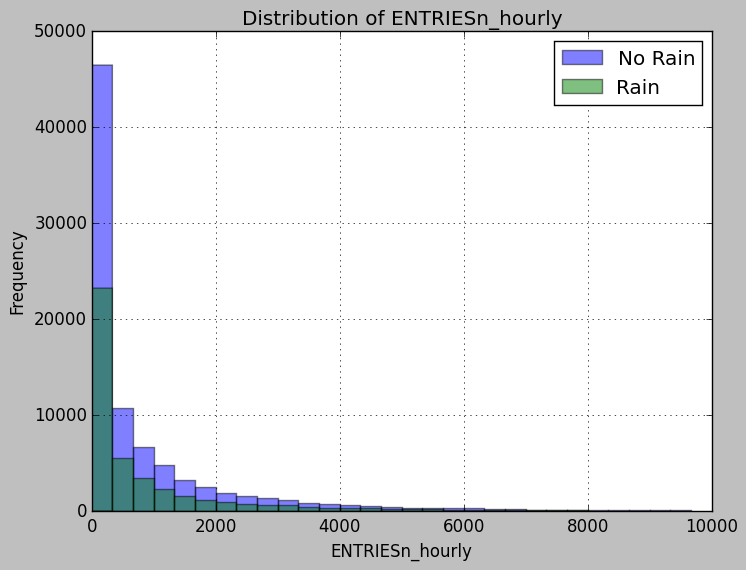

In [10]:
import matplotlib.pyplot as plt

num_bins = 30
start_bin = min(turnstile_master['ENTRIESn_hourly'])
stop_bin = 10000 # max(turnstile_master['ENTRIESn_hourly'])
bin_width = (stop_bin - start_bin)/num_bins

bin_list = np.arange(start_bin, stop_bin, bin_width)

ax = turnstile_master[turnstile_master.rain == 0]['ENTRIESn_hourly'].plot(kind='hist', 
                                                                          bins = bin_list, 
                                                                          label='No Rain', 
                                                                          alpha = 0.5)

ax = turnstile_master[turnstile_master.rain == 1]['ENTRIESn_hourly'].plot(kind='hist', 
                                                                          bins = bin_list, 
                                                                          label='Rain',
                                                                          alpha = 0.5)
ax.legend()
ax.set_ylabel('Frequency')
ax.set_xlabel('ENTRIESn_hourly')
ax.set_title('Distribution of ENTRIESn_hourly')

The distribution of ENTRIESn_hourly appears to not be normally distributed and skewed to the right on both rainy and non-rainy days.  The mode appears to be within the smallest bin for both distributions.  There are far fewer observations on rainy days than non-rainy days.

### 3.2 Average Hourly Ridership by Day of Week

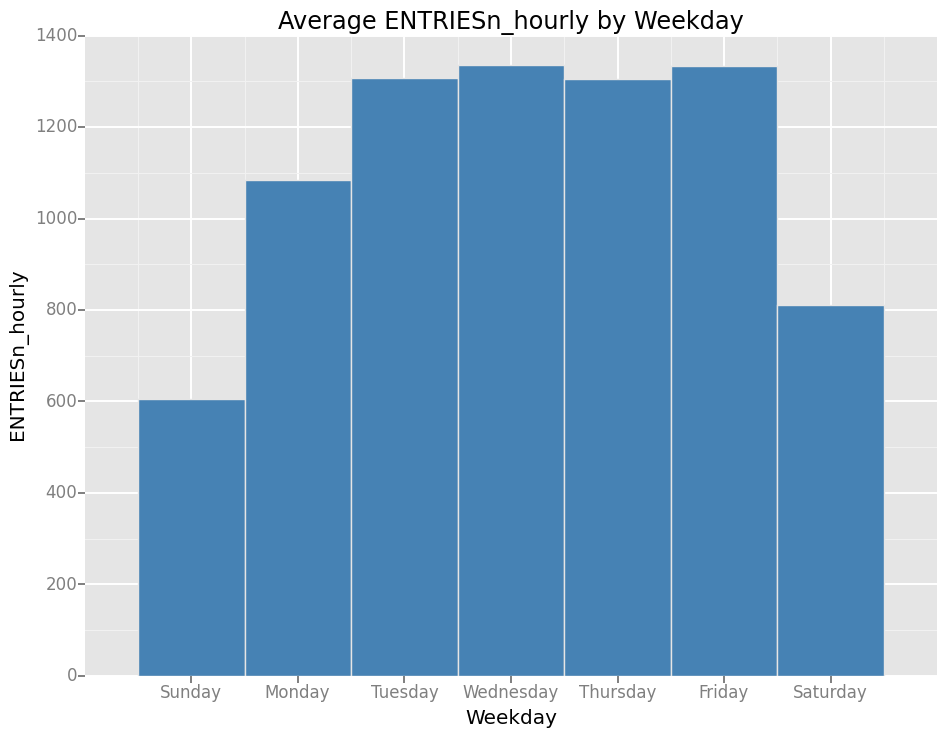

<ggplot: (287503837)>


In [11]:
import pandasql
from ggplot import *

df = turnstile_master[['DATEn', 'ENTRIESn_hourly', 'rain']]
 
q = """
    select cast(strftime('%w', DATEn) as integer) as weekday, sum(ENTRIESn_hourly)/count(*) as hourlyentries
    from df
    group by cast(strftime('%w', DATEn) as integer)
    """
    
#Execute SQL command against the pandas frame
rainy_days = pandasql.sqldf(q.lower(), locals())


print ggplot(rainy_days, aes('weekday', 'hourlyentries')) + \
        geom_bar(fill = 'steelblue', stat='bar') + \
        scale_x_continuous(name="Weekday", 
                            breaks=[0, 1, 2, 3, 4, 5, 6], 
                            labels=["Sunday", 
                                    "Monday",
                                    "Tuesday",
                                    "Wednesday", 
                                    "Thursday", 
                                    "Friday", 
                                    "Saturday"]) + \
        ggtitle("Average ENTRIESn_hourly by Weekday") + \
        ylab("ENTRIESn_hourly")

The above bar chart shows the average hourly ridership by day of week.  The sum of ENTRIESn_hourly by day of week was divided by the count of rows for a given day of week (as each row represents an hour’s worth of data).  The bar chart shows that the average hourly ridership is higher on weekdays than weekends, with Saturday seeing significantly higher ridership than Sunday.  It appears that the average hourly ridership on Monday is significantly different than the rest of the weekdays.  This may be due to a seasonal effect of Monday holidays.  The given data set is a sample from May 2011.  There is at least one major holiday that falls on Monday in the month of May: Memorial Day.

## Section 4: Conclusion

### 4.1 Do More People Ride the Subway When it is Raining?

Based on this analysis, I believe that more people ride the NYC subway when it is raining.

### 4.2 Rationale

As seen in [Section 1.3](#1.3-Test-Results), the mean of ENTRIESn_hourly is greater for hours with rain than without (1,105 vs. 1,090).  Additionally, a Mann-Whitney U-Test shows that the ENTRIESn_hourly sample with rain appears to be drawn from a different distribution (or population) than the ENTRIESn_hourly sample from hours without rain.

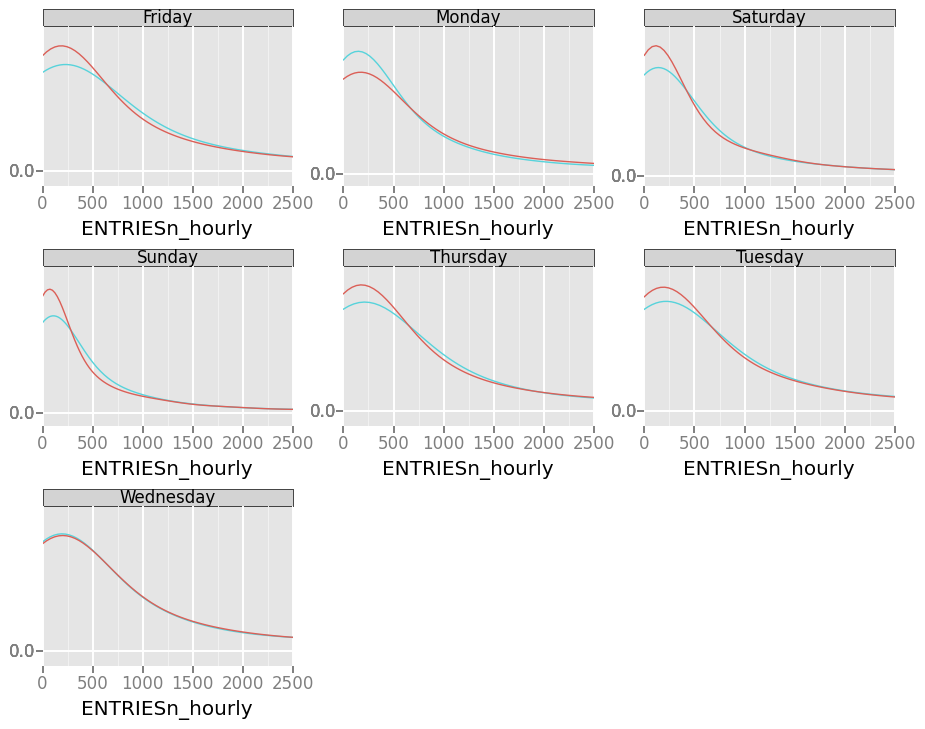

<ggplot: (280631061)>


In [12]:
df = turnstile_master[['DATEn', 'ENTRIESn_hourly', 'rain']]
df.is_copy = False

# get the weekday as a string
f = lambda x: datetime.strptime(x, "%Y-%m-%d").strftime('%A') 

df['weekday'] = df['DATEn'].apply(f)

print ggplot(aes(x='ENTRIESn_hourly', color='rain'), data = df) \
        + geom_density() \
        + xlim(0,2500) \
        + facet_wrap('weekday')

This faceted grid shows the density functions of ENTRIESn_hourly with and without rain for each day of the week.  Currently legends do not work within ggplot facets.  Red represents without rain, and blue represents with rain.  It appears for every day, except Monday, that the distribution of ENTRIESn_hourly has a fatter right tail when there is rain.

## Section 5: Reflection

### 5.1 Shortcomings of the Data Set and Methods of Analysis

The data set provided contains only one month of MTA data.  This smaller data set is subject to effects of seasonality, as the time of year may also affect ridership.  Additionally, the Month of May contains a Monday holiday, which appears to have an affect on the data in the visualizations in [Section 3.2](#3.2-Average-Hourly-Ridership-by-Day-of-Week) and [Section 4](#Section-4:-Conclusion).  The largest shortcoming I see with this data set is that it appears that the MTA component of the data is produced on an hourly basis, but it is joined to daily weather data.  For example, if it rained at any point in a given day, every hour of that day will reflect that it rained.  This prevents a truly granular analysis of how the weather can affect ridership within a day.